# Benchmarking of various implementations of FADDEEVA's error functions

## I. Setup

Import the multiprecision library `mpmath` as a reference for accuracy benchmarks:

In [78]:
import mpmath

Import the rest of the usual lot:

In [79]:
import numpy as np
import scipy
import ctypes
import sys
import time
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [80]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline

sns.set_style("white")
cmap = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 256))
cmap2 = matplotlib.colors.ListedColormap(sns.cubehelix_palette(8, 256))
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

a timer class for a more convenient timing

In [81]:
class Timer(object):
    '''Uses time.time() bc timer.clock() doesn't work with GPU/...'''
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval_s = self.end - self.start

The dictionary `wofz_impl` accesses the various function implementations.

Input interface is `wofz_impl[<implementation-folder>](x, y)`: 
`x` is the real and `y` is the imaginary part of the input, both should be numpy arrays (i.e. provide the ctypes field).

In [82]:
wofz_impl = dict()

For argument types needing double pointers, use the ctypes pointer provided by NumPy:

In [83]:
from numpy.ctypeslib import ndpointer
np_double_p = ndpointer(dtype=np.float64)

`ctypes` libraries are loaded into the dictionary `dlls`:

In [84]:
dlls = dict()

Note: np.vectorize is purely for convenience and does not yield any speedup/loss. Essentialy a loop around the main function call.

### mpmath (reference)

set the precision:

In [85]:
mpmath.mp.dps = 50

prepare the `wofz_impl` entry:

In [86]:
def wofz(x, y):
    z = mpmath.mpc(x, y)
    w = mpmath.exp(-z**2) * mpmath.erfc(z * -1j)
    return w.real, w.imag
wofz_impl['mp'] = np.vectorize(wofz)

### scipy (version > 0.14)

http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package

In [87]:
from scipy.special import wofz as scipy_wofz

prepare the `wofz_impl` entry:

In [88]:
def wofz(x, y):
    z = scipy_wofz(x + 1j*y)
    return z.real, z.imag
wofz_impl['scipy'] = wofz

### cernlib-c


loading the external shared C library:

In [89]:
dlls['c'] = ctypes.cdll.LoadLibrary('cernlib-c/wofz.so')
dlls['c'].cerrf.restype = None
dlls['c'].cerrf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

prepare the `wofz_impl` entry:

In [90]:
def wofz(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c'].cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c'] = np.vectorize(wofz)

### cernlib-cuda-1

try whether PyCUDA is available for the CUDA FADDEEVA version:

In [91]:
i_pycuda = False
try:
    from pycuda.autoinit import context
    from pycuda import gpuarray
    from pycuda.elementwise import ElementwiseKernel
    i_pycuda = True
except ImportError as e:
    print 'No PyCUDA available, as per error message:'
    print e.message

prepare the CUDA kernel for the wofz function:

In [92]:
if i_pycuda:
    kernel = ElementwiseKernel(
        'double* in_real, double* in_imag, double* out_real, double* out_imag',
#         'out_real[i] = in_real[i]; out_imag[i] = in_imag[i]',
        'wofz(in_real[i], in_imag[i], &out_real[i], &out_imag[i]);',
        'wofz_kernel',
        preamble=open('cernlib-cuda-1/wofz.cu', 'r').read()
    )

prepare the `wofz_impl` entry:

In [93]:
if i_pycuda:
    def wofz(x, y):
        in_real = gpuarray.to_gpu(np.atleast_1d(x).astype(np.float64))
        in_imag = gpuarray.to_gpu(np.atleast_1d(y).astype(np.float64))
        out_real = gpuarray.empty(in_real.shape, dtype=np.float64)
        out_imag = gpuarray.empty(in_imag.shape, dtype=np.float64)
        kernel(in_real, in_imag, out_real, out_imag)
        return out_real.get(), out_imag.get()
    wofz_impl['cuda'] = wofz

### cernlib-f90-1

import and numpy-vectorise the first f90 version:

In [94]:
sys.path.append('cernlib-f90-1')
from wwerf import ccperrfr

wofz_impl['f90-1'] = np.vectorize(ccperrfr)

### cernlib-f90-2

import and numpy-vectorise the second f90 version:

In [95]:
sys.path.append('cernlib-f90-2')
from wwerf2 import errf

wofz_impl['f90-2'] = np.vectorize(errf)

### cernlib-python-1

In [96]:
sys.path.append('cernlib-python-1')
from mywwerf import wwerf

wofz_impl['py'] = np.vectorize(wwerf)

### cernlib-root-adapted
Using the complex exponential function in c to compute exp(-z*z)*erfc(-iz)

In [97]:
dlls['c-root-adapt'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc.so')
#wofz
dlls['c-root-adapt'].wofz.restype = None
dlls['c-root-adapt'].wofz.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt'].wofz(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt'] = np.vectorize(wofz_root)

### cernlib-root-adapted: 2
Using the formula exp(-(a+ib)^2) = e^(-a^2+b^2) cos(2 a b)-i e^(-a^2+b^2) sin(2 a b)

In [98]:
#wofz
dlls['c-root-adapt'].wofz_2.restype = None
dlls['c-root-adapt'].wofz_2.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root_2(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt'].wofz_2(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt_2'] = np.vectorize(wofz_root_2)

### cernlib-root-adapted cython

In [99]:
sys.path.append('cernlib-root-adapted/')

### cernlib-root-adapted -DFAST_IMPL

In [100]:
dlls['c-root-adapt-fast'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc_fast.so')
dlls['c-root-adapt-fast'].wofz.restype = None
dlls['c-root-adapt-fast'].wofz.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root_fast(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt-fast'].wofz(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt-fast'] = np.vectorize(wofz_root_fast)
#wofz_impl['c-root-adapt-fast-novec'] = wofz_root_fast

### cernlib-root-adapted -DSINCOS

In [101]:
dlls['c-root-adapt-sincos'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc_sincos.so')
dlls['c-root-adapt-sincos'].wofz.restype = None
dlls['c-root-adapt-sincos'].wofz.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root_sincos(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt-sincos'].wofz(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt-sincos'] = np.vectorize(wofz_root_sincos)
#wofz_impl['c-root-adapt-sincos-novec'] = wofz_root_sincos

## II. Accuracy Benchmark

### dirty hands-on, just trying what happens:

In [102]:
params = (np.asarray(1e-4,dtype=np.float64), np.asarray(3.1, dtype=np.float64)) #works
#params = (np.asarray(0.,dtype=np.float64), np.asarray(0., dtype=np.float64)) #works
#params = (-1.,-1.) #works

In [103]:
wofz_impl['scipy'](*(params))

(0.17371840845930026, 5.1325033701771152e-06)

In [104]:
wofz_impl['c'](*(params))

(array(0.17371840845929892), array(5.1325033701841845e-06))

In [105]:
wofz_impl['cuda'](*(params))

(array([ 0.17371841]), array([  5.13250337e-06]))

In [106]:
wofz_impl['f90-1'](*(params))

(array(0.17371841748644712), array(5.132503636890913e-06))

In [107]:
wofz_impl['f90-2'](*(params))

(array(0.17371840845929887), array(5.132503370184184e-06))

In [108]:
wofz_impl['py'](*(params))

(array(0.16119226480649576), array(2.8358469447559325e-06))

In [109]:
wofz_impl['c-root-adapt'](params[0], params[1])

(array(0.17371840845930023), array(5.132503370177115e-06))

In [110]:
wofz_impl['c-root-adapt_2'](params[0], params[1])

(array(0.17371840845930023), array(5.132503370177115e-06))

In [111]:
wofz_impl['c-root-adapt-fast'](*(params))

(array(0.17371840823781087), array(5.132503372478321e-06))

In [112]:
wofz_impl['c-root-adapt-sincos'](*(params))

(array(0.17371840845930023), array(5.132503370177115e-06))

### Accuracy within range 10^-8 to 10^8

(outside of this, the `mpmath` multiplications of extremely large and small factors do not behave well)

define range:

In [113]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

the reference values via `mpmath`:

In [114]:
wr_ref, wi_ref = wofz_impl['mp'](x, y)

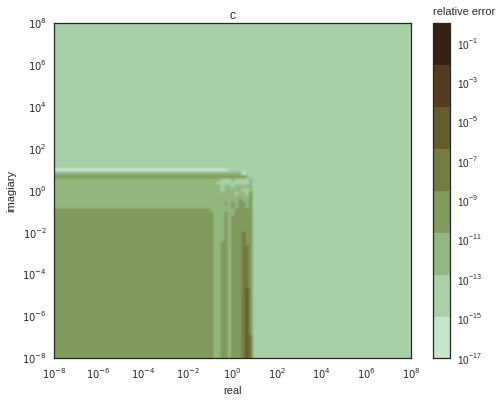

In [115]:
def plot_error(x,y,z, title, unify=True):
    fig, ax = plt.subplots(figsize=(8,6))
    if unify:
        z = np.clip(a=z, a_min=1e-17, a_max=1e0)
        im  = ax.imshow(
                   #np.vectorize(mpmath.log10)(z).astype(np.float64),
                   z.astype(np.float64),
                   origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
                   vmin=1e-17, vmax=1e0, norm=LogNorm(),
                   cmap=cmap2)
    else:
        im = ax.imshow(np.vectorize(mpmath.log10)(z).astype(np.float64),
                       origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
                       cmap=cmap2)

    # Plot look: axes, title, ticks, ...
    cbar = plt.colorbar(im)
    cbar.set_label('relative error', labelpad=-18, y=1.05, rotation=0)
    ax.set_title(title)
    ax.set_xlabel('real')
    ax.set_ylabel('imagiary')
    ax.set_xticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    ax.set_yticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    
    return fig, ax

test = True
if test is True:
    wr, wi = wofz_impl['c'](x, y)
    z = abs(wr - wr_ref)/wr_ref
    #z = abs(wi - wi_ref)/wi_ref
    fig, ax = plot_error(x,y,z, title='c',unify=True)

### Compare the relative errors for the different implementations
You can either plot the real or the imaginar parts by setting z to real_error or imag_error

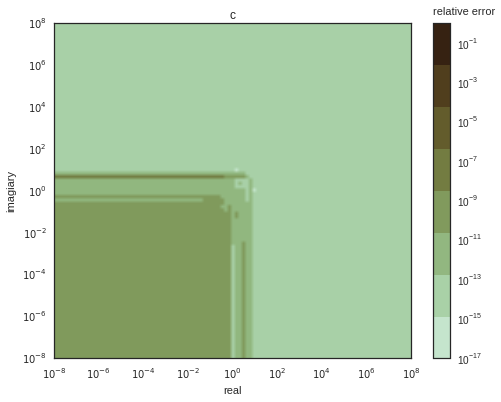

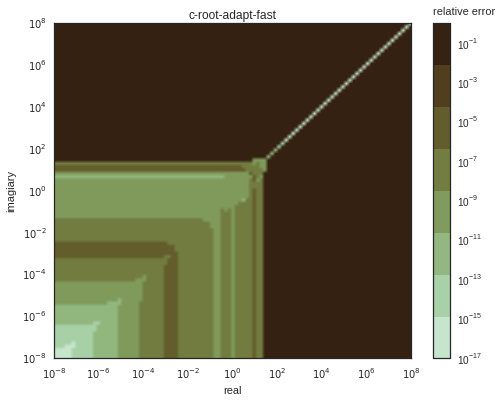

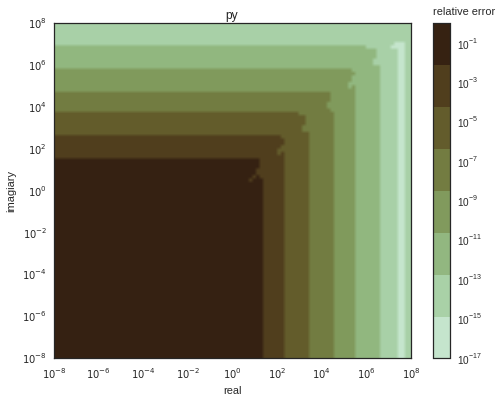

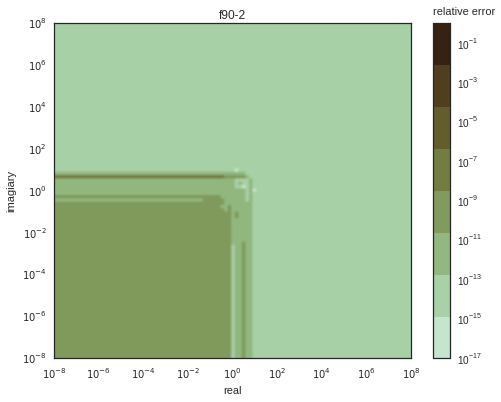

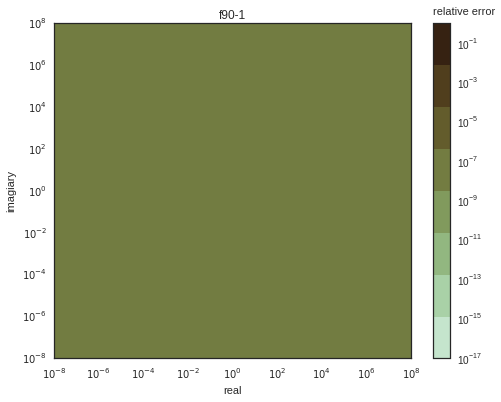

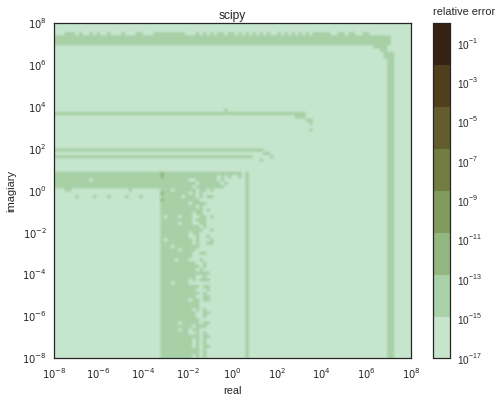

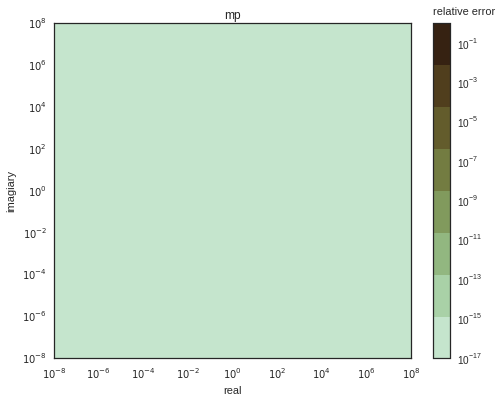

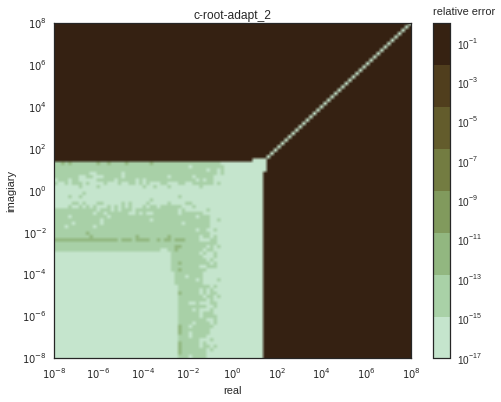

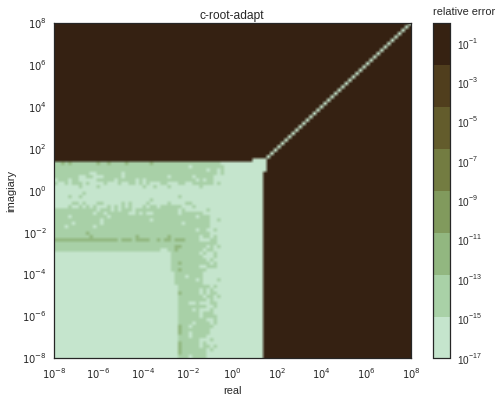

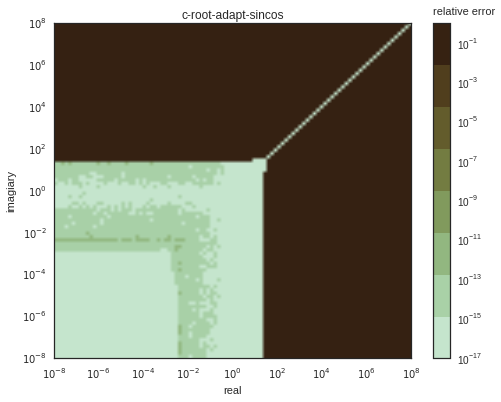

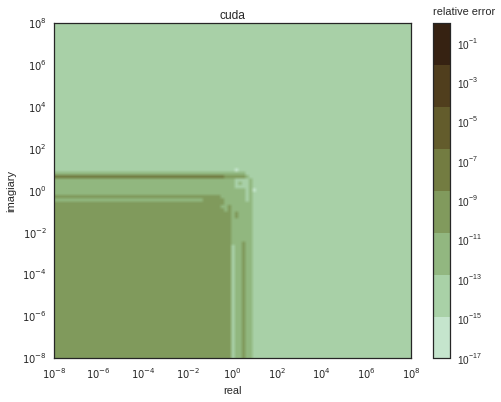

In [116]:
for implementation, function in wofz_impl.iteritems():
    wr, wi = function(x, y)
    real_error = abs(wr - wr_ref)/wr_ref
    imag_error = abs(wi - wi_ref)/wi_ref
    z = imag_error
    plot_error(x,y,z, title=implementation, unify=True)


## III. Timing Benchmark

to be provided

In [123]:
def plot_timing(x,y,z, title):
    fig, ax = plt.subplots(figsize=(8,6))
    z = np.clip(a=z, a_min=1e-17, a_max=1e0)
    im  = ax.imshow(
                   z.astype(np.float64),
                   origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
    )


    # Plot look: axes, title, ticks, ...
    cbar = plt.colorbar(im)
    cbar.set_label('t [s] per call', labelpad=-18, y=1.05, rotation=0)
    ax.set_title(title)
    ax.set_xlabel('real')
    ax.set_ylabel('imagiary')
    ax.set_xticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    ax.set_yticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    
    return fig, ax

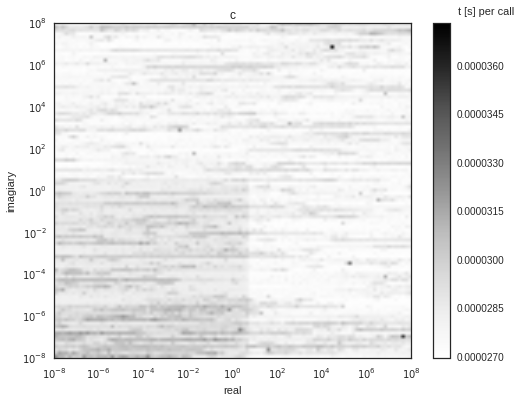

In [124]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)


def dummy(a,b):
    pass

def timeit(x,y, function, nrep_timing=3, n_entries_array=50):
    '''Time the implementation on the arrays x,y = x +iy'''
    T = np.zeros(x.shape)
    timings = np.zeros(nrep_timing)
    for el in xrange(len(x)):
        for el2 in xrange(len(x[0])):
            xx = np.ones(n_entries_array)*x[el][el2]
            yy = np.ones(n_entries_array)*y[el][el2]
            for i in xrange(nrep_timing):
                with Timer() as t:
                    wr, wi = function(xx, yy)
                timings[i] = t.interval_s
            T[el,el2] = np.mean(timings)/n_entries_array
            dummy(wr,wi) # use wr, wi, otherwise they might get optimized away
    return T
if test is True:
    fn = wofz_impl['c']
    z = timeit(x,y, fn)
    plot_timing(x,y,z, 'c')

c
c-root-adapt-fast
py
f90-2
f90-1
scipy
c-root-adapt_2
c-root-adapt
c-root-adapt-sincos
cuda


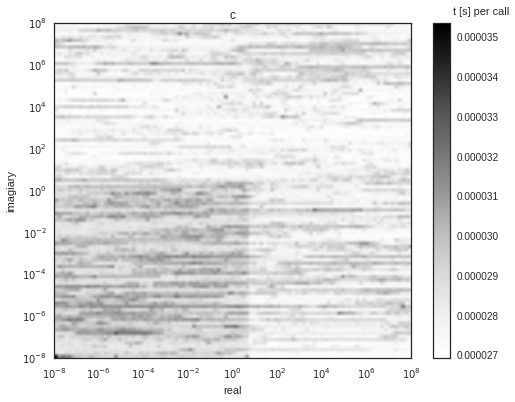

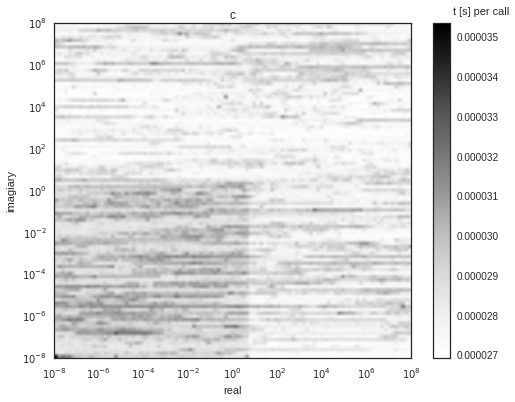

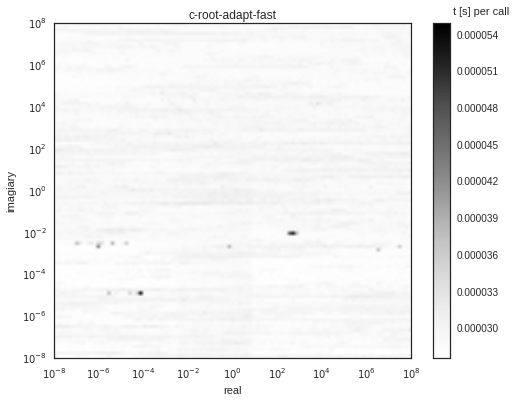

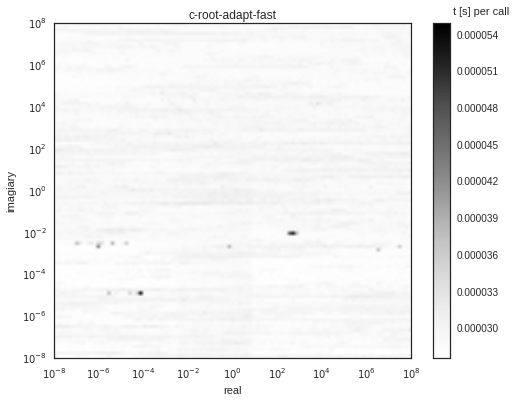

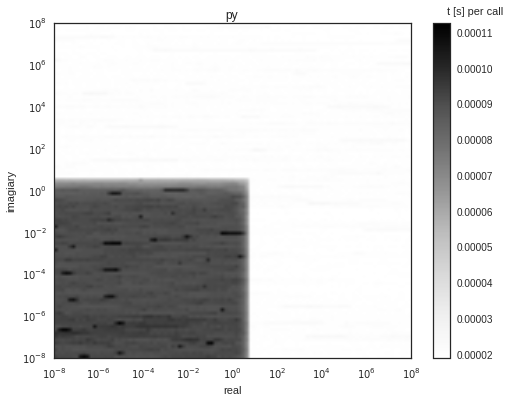

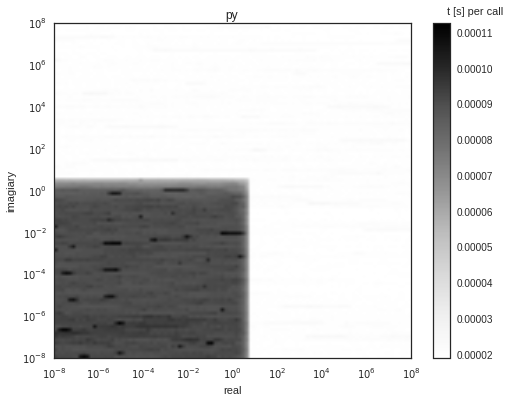

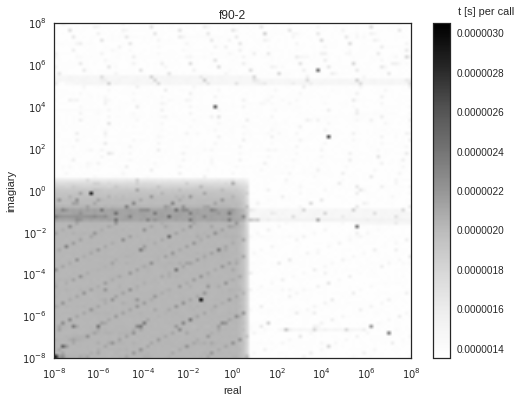

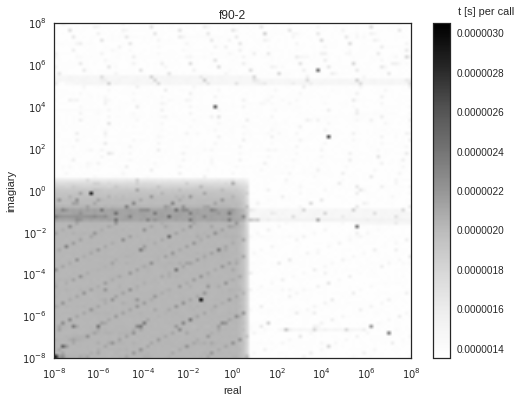

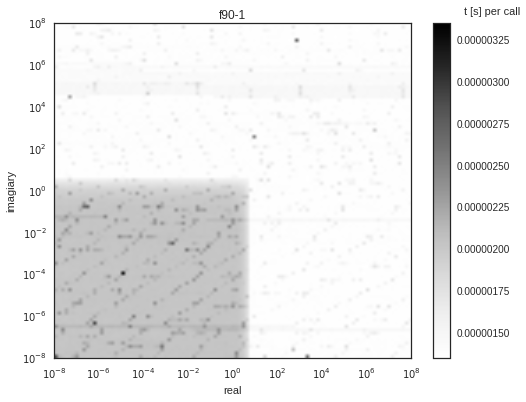

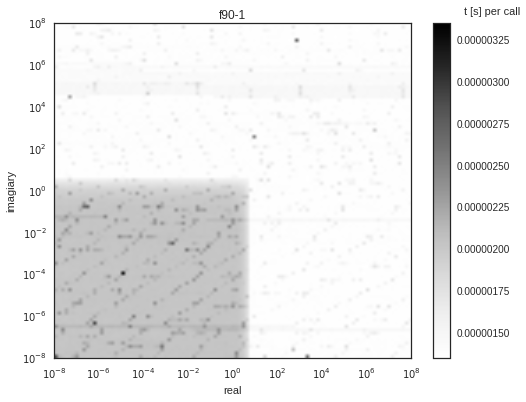

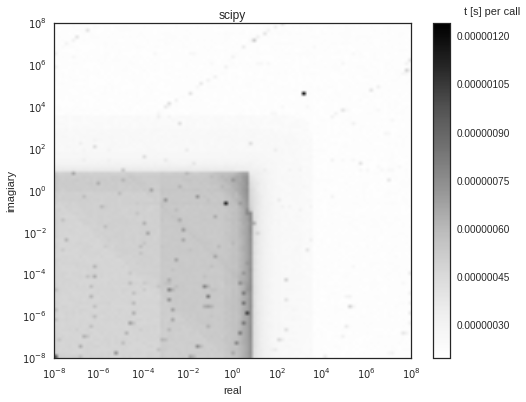

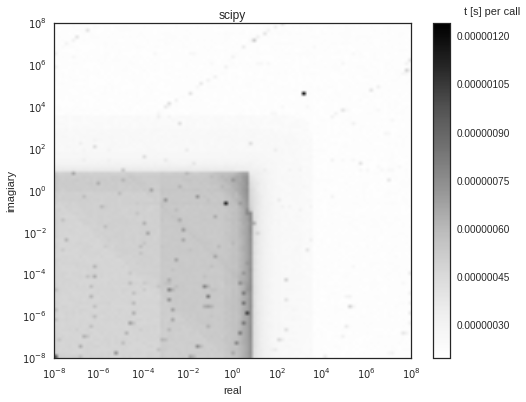

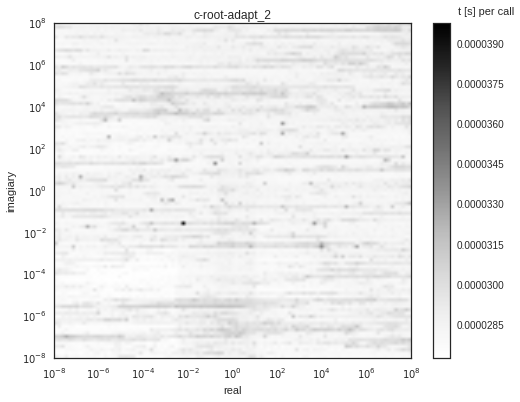

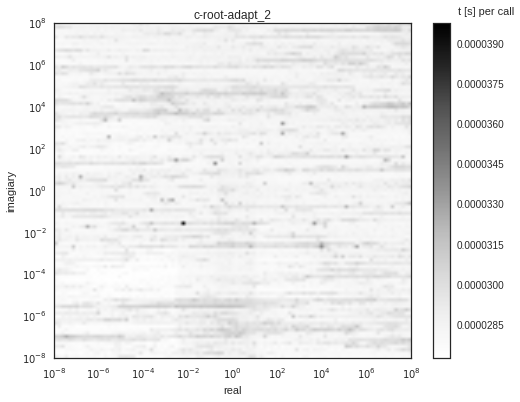

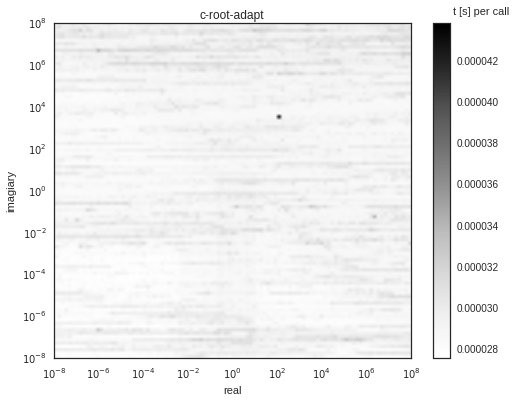

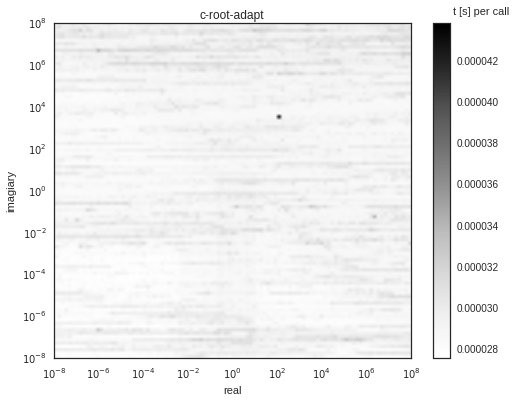

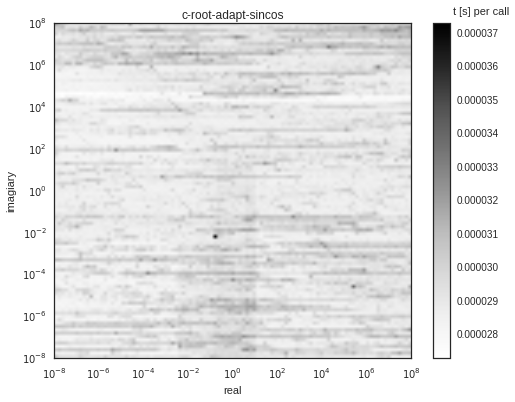

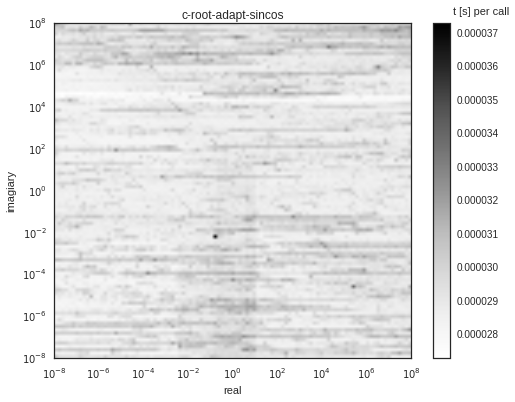

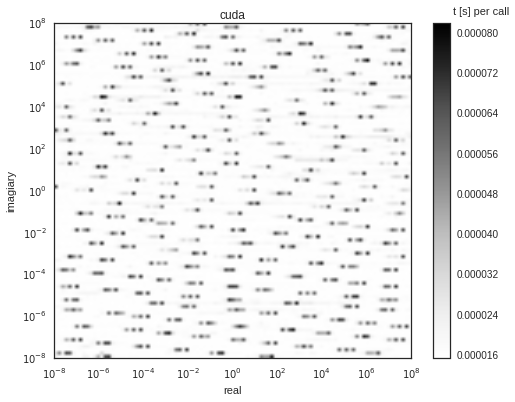

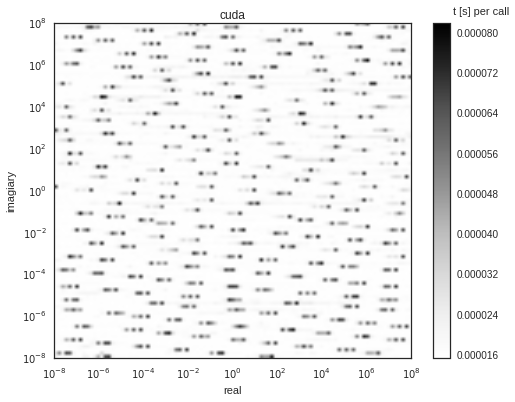

In [125]:
for implementation, function in wofz_impl.iteritems():
    if implementation is not 'mp':
        print(implementation)
        z = timeit(x,y, function)
        plot_timing(x,y,z, title=implementation)
        plot_timing(x,y,z, title=implementation)

In [120]:
x = np.random.normal(0., 1., 100000)
y = np.random.normal(0., 1., 100000)

stats = %prun -r wofz_impl['c-root-adapt'](x,y)


### Memory footprint:
Computed by hand, counting the number of variables and lookup tables. Neglecting the memory needed by calls to pow, exp etc. Assuming 4 bytes for integers. Not counting the memory for the input and output. Constants are treated as variables of the corresponding size. Variables: all declarations of variables, even if they might be eliminated by the compiler. Tables: all memory used to store fixed constants, lookup tables, ... . Some values are estimates because they depend on the program flow (if/else branches).
- cernlib-c: 684 Bytes
- f90-1: 692 Bytes
- f90-2: 716 Bytes
- cernlib-cuda: 684 Bytes
- cernlib-root-adapted-FAST_IMPL: Tables: 704 Bytes, Vars: ~350 Bytes
- cenlib-root-adapted: Tables: 2688 Bytes, Vars: ~ 600 Bytes


